# Simulate Sequences, BCP

This Jupyter Notebook combines the functionality of bcp and HTP_CompDrift. It simulates the construction of an RHP with four specified monomers and then solves for the reaction conditions required given four specified monomers. The calculations require three database files to be present: `initiators.txt` which contains a list of initiators, `reagent_master_list.txt` which is a master database of reagents, and `rr_data.txt` which contains the reactivity ratio data of monomer components. Currently, the three are dummy data files but can be expanded.

In [1]:
import pandas as pd
import numpy as np
import glob, os
import csv
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from tqdm import tqdm_notebook
from itertools import tee
import re

from simulate import run_simulation, rr_extracter
from bcp_v2 import main as calculate_bcp
from jupyter_utils import plot_heterogeneity

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


#SMALL_SIZE = 20
#MEDIUM_SIZE = 25
#BIGGER_SIZE = 35
XUGROUP_IGOR_MACRO_SIZE = 22

plt.rc('font', family='Helvetica', size=XUGROUP_IGOR_MACRO_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=XUGROUP_IGOR_MACRO_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=XUGROUP_IGOR_MACRO_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=XUGROUP_IGOR_MACRO_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=XUGROUP_IGOR_MACRO_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=XUGROUP_IGOR_MACRO_SIZE)    # legend fontsize
plt.rc('figure', titlesize=XUGROUP_IGOR_MACRO_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=1.5) # thicker lines to match Xu Group Igor Macros

df_new = pd.read_csv('data/reagent_master_list.txt', delimiter='\t')
df_new.index = df_new['Code']

rr_df = pd.read_csv('data/rr_data.txt', delimiter='\t')
rr_df.index = rr_df['reac']
rr_df = rr_df.drop('reac', 1)

### Input Program Variables

In [2]:
#LIST 4 MONOMERS DESIRED FOR CONSTRUCTION
monomers = ["MMA","TBMA","NHSMA","STY"]

#SPECIFY MOLAR RATIOS
MRs = [4,3,2,1]

#SET CONVERSION % AND AVERAGE DP
conv = 0.5
avgDP = 105

#SET N_CHAINS, CTP, and whether to PRUNE_OLIGOMERS
N_CHAINs = 1000
CTP = 1
PRUNE_OLIGOMERS = 0

#SET INTERNAL STANDARD, INITIATOR, RAFT AGENT, AND SOLVENT
int_std = 'TriOx'
int_std_mw = 1
initiator = 'AIBN'
init_conc = 1
raft = 'RAFTPBT'
raft_mw = 2
solvent = 'Tol'

#SET RAFT-TO-INITIATOR RATIO AND TARGET MW
i_r_ratio = 1
target_mw = 5

#SET OTHER REACTION PARAMETERS
rxn_scale = 1 #MMOL
rxn_vol = 1 #LITERS
rxn_temp = 20 #CELSIUS

### Runs Polymer Simulator and BCP

Simulation done! Sequence file saved @ outputs/NM4_MR[4, 3, 2, 1]_NC1000_DP105_conv50_CTP100_FILT0.csv


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


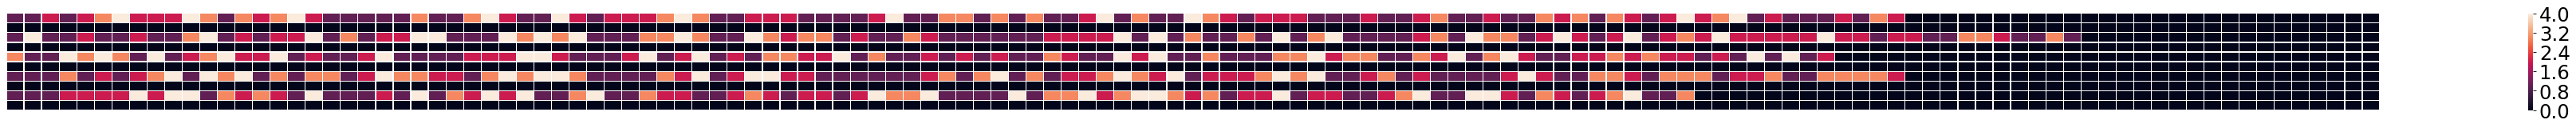

initial guess mw: 13391.05


E:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


kd:  4.418944720260815e-08
T0:  189415.66563374992
I0:  378831.3312981893
M0:  0.9999999999999999
time: 32973.394583549816


('test experiment',
 5,
 325.47033379607154,
                                               vol (mL)     mass (mg)      conc (M)   mols (mol)
 Methyl methacrylate                       4.190000e-02  3.920730e+01  4.000000e-01       0.0004
 tert-Butyl methacrylate                   4.780000e-02  4.181930e+01  3.000000e-01       0.0003
 NHS Methacrylate                         -0.000000e+00  3.579130e+01  2.000000e-01       0.0002
 Styrene                                   1.050000e-02  9.574300e+00  1.000000e-01       0.0001
 Trioxane                                 -0.000000e+00  6.010000e-02  1.000000e-02       0.0000
 Azobisisobutryonitrile                    3.110395e+07  3.110395e+07  1.894157e+05     189.4157
 Phthalimidomethyl butyl trithiocarbonate -0.000000e+00  6.164912e+07  1.894157e+05     189.4157
 Toluene                                  -3.110395e+07 -2.706043e+10 -2.936882e+08 -293688.2204
 Total                                     1.000000e+00 -2.696768e+10 -2.933094e+0

In [3]:
#NORMALIZES MONOMER RATIOS TO SUM TO 100
N_MONs = len(monomers)
total_mw = sum(MRs) / 100
#rr_extracter takes a 2-D reactivity dataframe and extracts a 2-D list of reactivity of monomers listed.
RRs = rr_extracter(rr_df, monomers)

#SIMULATES POLYNOMIAL CONSTRUCTION
run_simulation(N_MONs, N_CHAINs, MRs, RRs, avgDP, conv, CTP, PRUNE_OLIGOMERS)

#PLOTS HETEROGENEITY
plot_heterogeneity()

#CALCULATES BCP
calculate_bcp('test experiment', monomers[0], monomers[1], monomers[2], monomers[3], 
              MRs[0] / total_mw, MRs[1] / total_mw, MRs[2] / total_mw, MRs[3] / total_mw, 
              int_std, int_std_mw, initiator, init_conc, raft, raft_mw, i_r_ratio,
              solvent, conv, target_mw, rxn_scale, rxn_vol, rxn_temp)